# Monte Carlo Pricing

The Purpose of this notebook is to practice and investigate Monte Carlo pricing technique for financial derivatives including their effectiveness, variance reduction techniques and limitations.

In [1]:
from scipy.stats import norm, t
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm

In [2]:
def payoff(S, K):
    return np.maximum(0, S - K)

In [3]:
def BSM(t, T, S, K):
    tau = T - t
    d1 = (np.log(S/K) + tau * (r + vol ** 2 / 2)) / (vol * np.sqrt(tau))
    d2 = d1 - vol * np.sqrt(tau)
    return norm.cdf(d1) - np.exp(- r * tau) * norm.cdf(d2)

### 1. Vanilla Call

First I attempt a standard Monte Carlo Simulation on a vanilla call option with S/K = 1

In [4]:
vol = 0.01
S_0 = 1
r = 0
T = 730
K = 1

In [58]:
print("BSM value = {}".format(BSM(0, T, S_0, K)))

BSM value = 0.1074613081660063


100%|██████████| 1000/1000 [05:25<00:00,  3.08it/s]

price estimate: 0.10751744961745281
error: 5.7238137747668506e-05

95% confidence interval(0.10748825974020883, 0.10756525604742259)


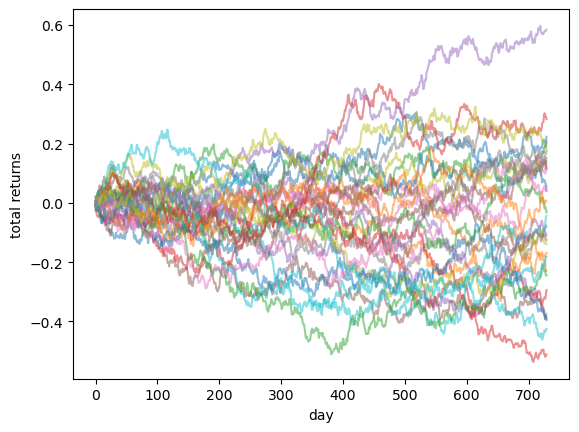

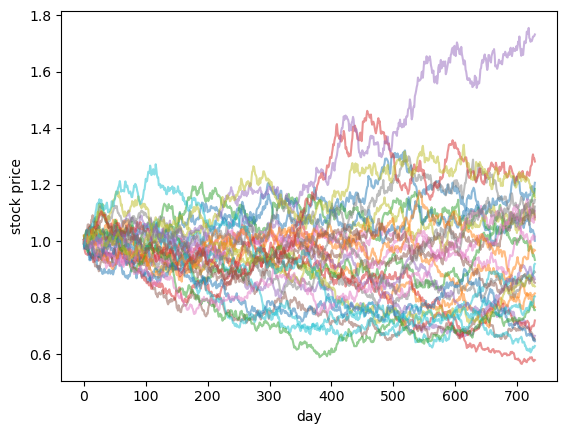

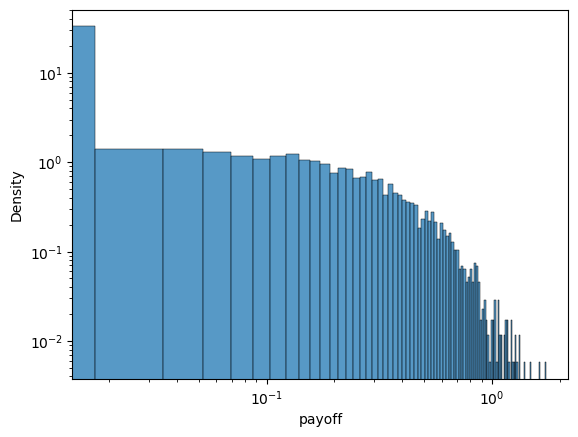

In [59]:
values = []
B = 1000

for i in tqdm(range(B)):
    N = 10000
    returns = pd.DataFrame(norm.rvs(loc = r, scale = vol, size=(T, N)))
    stocks = returns.add(1).cumprod()


    payoffs = payoff(stocks.iloc[-1,:],1)
    value = np.mean(payoffs)
    values.append(value)



price = np.mean(values)
se = np.std(values, ddof=1)/np.sqrt(B)

print("price estimate: {}".format(np.mean(values)))
print("error: {}\n".format(np.std(values, ddof=1)/np.sqrt(B)))
alpha = 0.05
print("95% confidence interval({}, {})".format(price - se * norm.cdf(alpha / 2), price + se * norm.cdf(1 - alpha / 2)))

plt.plot(returns.iloc[:,:30].cumsum(), alpha=0.5)
plt.xlabel('day')
plt.ylabel('total returns')
plt.show()

plt.plot(stocks.iloc[:,:30], alpha=0.5)
plt.xlabel('day')
plt.ylabel('stock price')
plt.show()

sns.histplot(payoffs, bins=100, stat='density')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('payoff')
plt.show()

### Importance Sampling

Next, I try to reduce the standard error of the result using importance sampling.

In [60]:
print("vol = {}, T = {}, K = {}".format(vol, T, K))
print("BSM value = {}".format(BSM(0, T, S_0, K)))

vol = 0.01, T = 730, K = 1
BSM value = 0.1074613081660063


100%|██████████| 1000/1000 [06:23<00:00,  2.61it/s]

price estimate: 0.10745589310320572
error: 1.895752668448771e-05

95% confidence interval(0.10744622528558367, 0.10747172680617903)


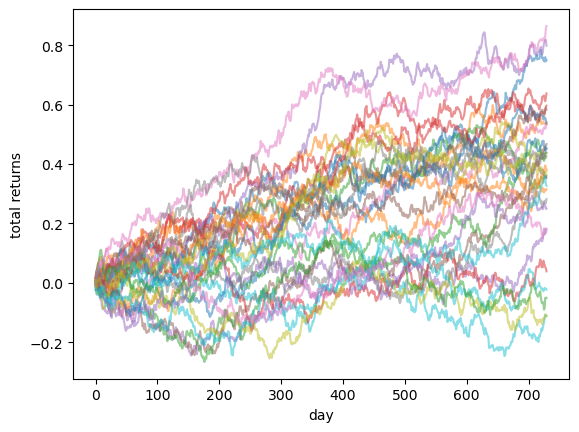

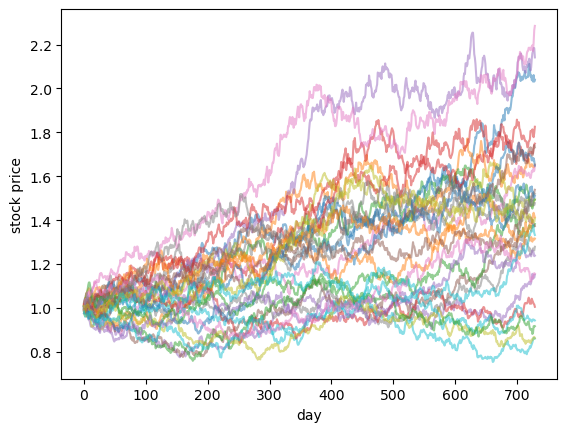

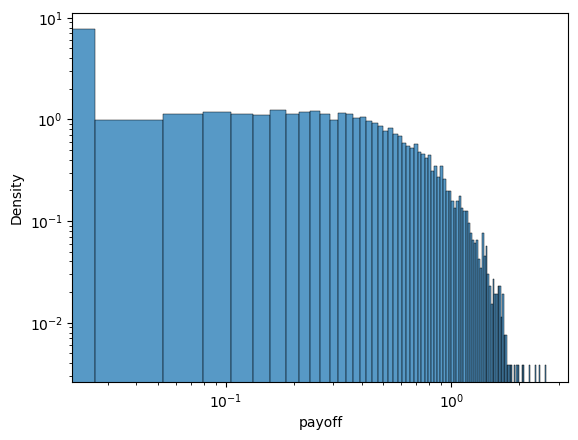

In [61]:
xs = np.linspace(-5 * vol * np.sqrt(T) + r * T, 5 * vol * np.sqrt(T) + r * T, 10000)
ys = np.maximum(np.exp(xs) - K, 0) * norm.pdf(xs, loc = r * T, scale = vol * np.sqrt(T))
mean = xs[np.argmax(ys)]/T
values = []
B = 1000

for i in tqdm(range(B)):
    N = 10000
    returns = pd.DataFrame(norm.rvs(loc = mean, scale = vol, size=(T, N)))
    stocks = returns.add(1).cumprod()
    payoffs = payoff(stocks.iloc[-1,:],1)
    total_return = returns.sum()

    integrand = payoffs * norm.pdf(total_return, loc = r * T, scale = vol * np.sqrt(T)) / norm.pdf(total_return, loc = mean * T, scale = vol * np.sqrt(T))

    value = np.mean(integrand)
    values.append(value)

price = np.mean(values)
se = np.std(values, ddof=1)/np.sqrt(B)

print("price estimate: {}".format(np.mean(values)))
print("error: {}\n".format(np.std(values, ddof=1)/np.sqrt(B)))
alpha = 0.05
print("95% confidence interval({}, {})".format(price - se * norm.cdf(alpha / 2), price + se * norm.cdf(1 - alpha / 2)))

plt.plot(returns.iloc[:,:30].cumsum(), alpha=0.5)
plt.xlabel('day')
plt.ylabel('total returns')
plt.show()

plt.plot(stocks.iloc[:,:30], alpha=0.5)
plt.xlabel('day')
plt.ylabel('stock price')
plt.show()

sns.histplot(payoffs, bins=100, stat='density')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('payoff')
plt.show()

### 3. Fat Tails

Here I compare vanilla call options for a stock where the returns are close to normally distributed, but have fat tails. This is modelled as a t - distribution with 10 degrees of freedom.

The plot below shows that the t distribution is close to the normal distribution within two standard distributions (~95% of the time), but has fatter tails. This means the chance of a large movement is higher in the t-distibutions. Here I whether this has a meaningful impact on the option price.

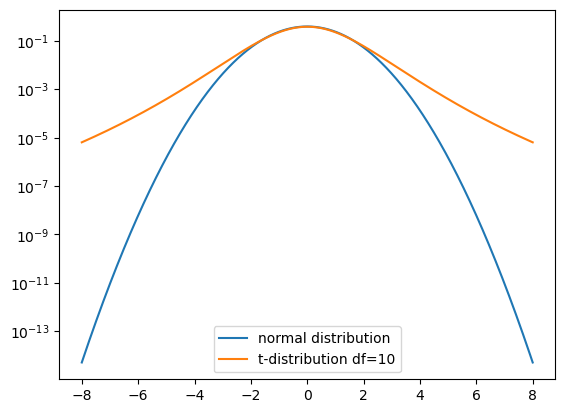

In [32]:
xs = np.linspace(-8, 8, 10000)
normys = norm.pdf(xs)
tys = t.pdf(xs, df=10)

plt.plot(xs, normys, label='normal distribution')
plt.plot(xs, tys, label = 't-distribution df=10')
plt.yscale('log')
plt.legend()
plt.show()

The BSM option price:

In [63]:
print("vol = {}, T = {}, K = {}".format(vol, T, K))
print("BSM value = {}".format(BSM(0, T, S_0, K)))

vol = 0.01, T = 730, K = 1
BSM value = 0.1074613081660063


I now perform a Monte Carlo Simulation where the returns have a fat tail. This is modelled with a t-distribution df = 10. I perform this many times and produce a 95% (normal) confidence interval. I do not use any importance sampling. The previous exercise showed that this had only limited variance reduction and we also do not know the distribution of the sum of t-distributions.

100%|██████████| 100/100 [01:18<00:00,  1.27it/s]

price estimate: 0.1200488961628377
error: 0.00020164347759845766

95% confidence interval(0.11994606353078917, 0.1202173128019878)


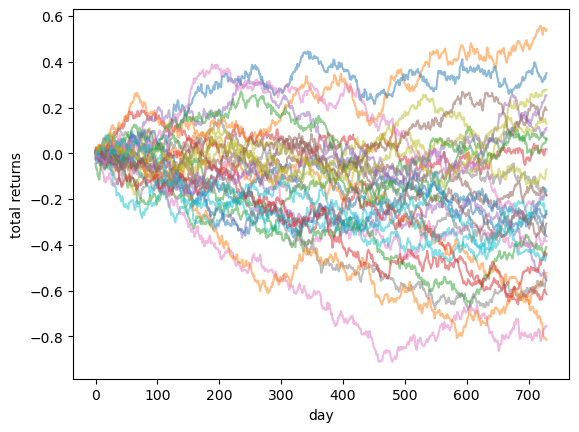

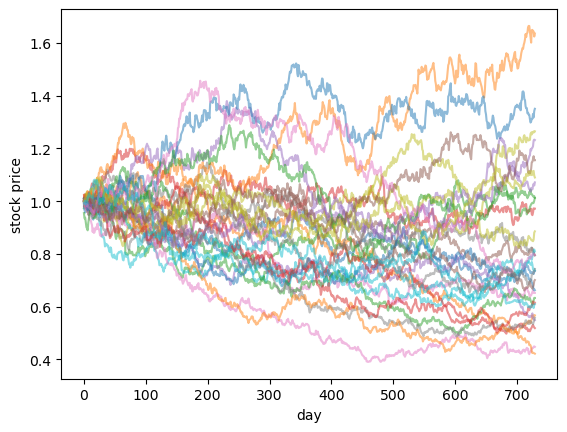

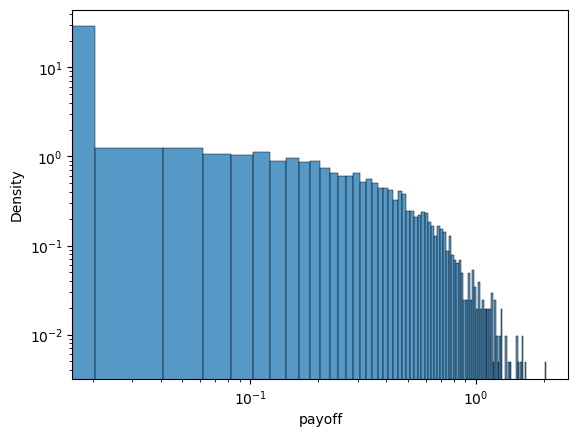

In [62]:
values = []
B = 100

for i in tqdm(range(B)):
    N = 10000
    returns = pd.DataFrame(t.rvs(df = 10, loc = r, scale = vol, size=(T, N)))
    stocks = returns.add(1).cumprod()


    payoffs = payoff(stocks.iloc[-1,:],1)
    value = np.mean(payoffs)
    values.append(value)



price = np.mean(values)
se = np.std(values, ddof=1)/np.sqrt(B)

print("price estimate: {}".format(np.mean(values)))
print("error: {}\n".format(np.std(values, ddof=1)/np.sqrt(B)))
alpha = 0.05
print("95% confidence interval({}, {})".format(price - se * norm.cdf(alpha / 2), price + se * norm.cdf(1 - alpha / 2)))

plt.plot(returns.iloc[:,:30].cumsum(), alpha=0.5)
plt.xlabel('day')
plt.ylabel('total returns')
plt.show()

plt.plot(stocks.iloc[:,:30], alpha=0.5)
plt.xlabel('day')
plt.ylabel('stock price')
plt.show()

sns.histplot(payoffs, bins=100, stat='density')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('payoff')
plt.show()

The confidence interval of (0.11994606353078917, 0.1202173128019878) suggests that the value of this option is underestimated by the Black Scholes equation. This difference can't be explained by statistical error. It is more likely the potential for larger movements means a higher chance for the call option to be far in the money, and therefore raises its value.

### 4. Exotic Options

4a. Lookback Option

In [56]:
vol = 0.01
S_0 = 1
r = vol/100
T = 730
K = 1

In [57]:
def lookback_payoff(S):
    #stock shape (T,N)
    return np.max(S, axis=0) - S.iloc[-1, :]

In [58]:
def lookback_BSM(S, M, t, T):
    tau = T - t
    def d1(z):
        return (np.log(z) + tau * (r + vol ** 2 / 2)) / (vol * np.sqrt(tau))
    def d2(z):
        return d1(z) - vol * np.sqrt(tau)
    
    z = S / M

    term1 = (1 + vol ** 2 / (2 * r)) * S * norm.cdf(d1(z))
    term2 = np.exp(- r * tau) * M * norm.cdf(- d2(z))
    term3 = - vol ** 2 / (2 * r) * np.exp(- r * tau) * z ** ( - 2 * r / (vol ** 2)) * S * norm.cdf(- d2 (1 / z)) - S

    return term1 + term2 + term3



In [59]:
print("vol = {}, r = {},  T = {}, K = {}".format(vol, r, T, K))
print("BSM value = {}".format(lookback_BSM(1, 1, 0, T)))

vol = 0.01, r = 0.0001,  T = 730, K = 1
BSM value = 0.1934711202832271


100%|██████████| 1000/1000 [05:51<00:00,  2.85it/s]

price estimate: 0.20065471111869707
error: 4.3685906088114884e-05

95% confidence interval(0.20063243250715967, 0.20069119845550168)


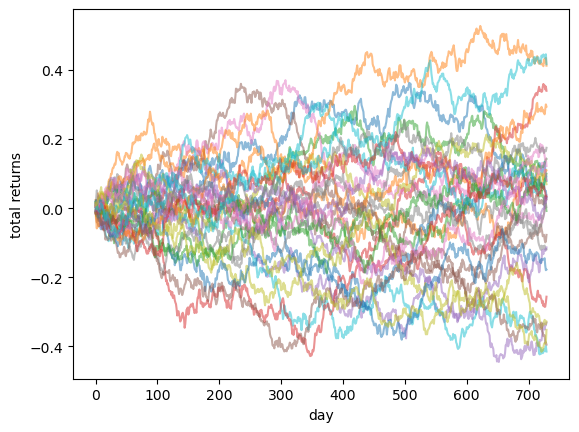

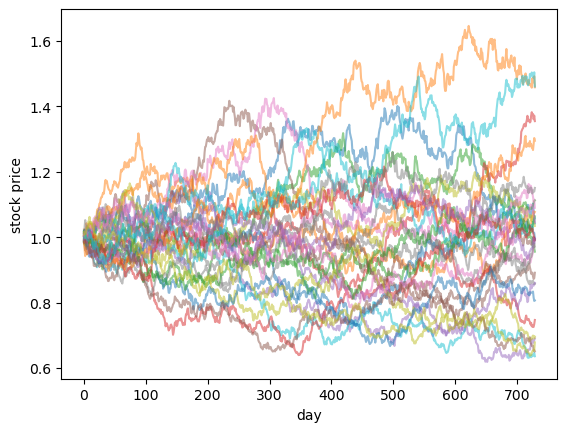

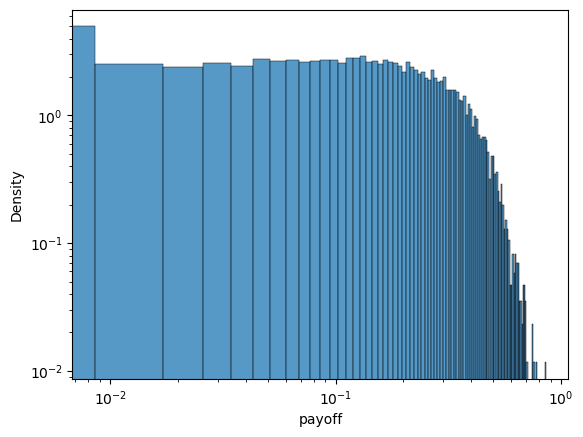

In [61]:
values = []
B = 1000

for i in tqdm(range(B)):
    N = 10000
    returns = pd.DataFrame(norm.rvs(loc = r, scale = vol, size=(T, N)))
    stocks = returns.add(1).cumprod()


    payoffs = lookback_payoff(stocks)
    value = np.mean(payoffs)
    values.append(value)



price = np.mean(values)
se = np.std(values, ddof=1)/np.sqrt(B)

print("price estimate: {}".format(np.mean(values)))
print("error: {}\n".format(np.std(values, ddof=1)/np.sqrt(B)))
alpha = 0.05
print("95% confidence interval({}, {})".format(price - se * norm.cdf(alpha / 2), price + se * norm.cdf(1 - alpha / 2)))

plt.plot(returns.iloc[:,:30].cumsum(), alpha=0.5)
plt.xlabel('day')
plt.ylabel('total returns')
plt.show()

plt.plot(stocks.iloc[:,:30], alpha=0.5)
plt.xlabel('day')
plt.ylabel('stock price')
plt.show()

sns.histplot(payoffs, bins=100, stat='density')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('payoff')
plt.show()

4b. Up-and-Out Call

In [62]:
def UaO_payoff(S, K, B):
    #stock shape (T,N)
    return (np.max(S, axis=0) < B) * np.maximum((S.iloc[-1, :] - K), 0)

In [67]:
def UaO_BSM(S, K, B, t, T):
    tau = T - t
    def d1(z):
        return (np.log(z) + tau * (r + vol ** 2 / 2)) / (vol * np.sqrt(tau))
    def d2(z):
        return d1(z) - vol * np.sqrt(tau)
    
    term1 = S * (norm.cdf(d1(S / K)) - norm.cdf(d1(S / B)))
    term2 = - np.exp(- r * tau) * K * (norm.cdf(d2(S / K)) - norm.cdf(d2(S / B)))
    term3 = - B * (S / B) ** (- 2 * r / (vol ** 2)) * (norm.cdf(d1(B ** 2 / (K * S))) - norm.cdf(d1(B / S)))
    term4 = np.exp(- r * tau) * K * (S / B) ** (1 - 2 * r / (vol ** 2)) * (norm.cdf(d2(B ** 2 / (K * S))) - norm.cdf(d2(B / S)))

    return term1 + term2 + term3 + term4


In [76]:
barrier = 1.2

print("vol = {}, r = {}, B = {}, T = {}, K = {}".format(vol, r, barrier, T, K))
print("BSM value = {}".format(UaO_BSM(1, 1, barrier, 0, T)))

vol = 0.01, r = 0.0001, B = 1.2, T = 730, K = 1
BSM value = 0.005672228261141887


In [77]:
print(BSM(0, T, 1, 1))

0.14261481974936374


100%|██████████| 1000/1000 [05:50<00:00,  2.85it/s]


price estimate: 0.006817669041305862
error: 7.680006565441542e-06

95% confidence interval(0.006813752449017927, 0.0068240835353912)


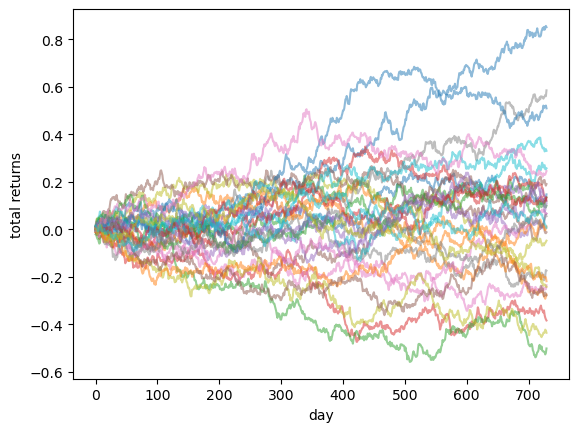

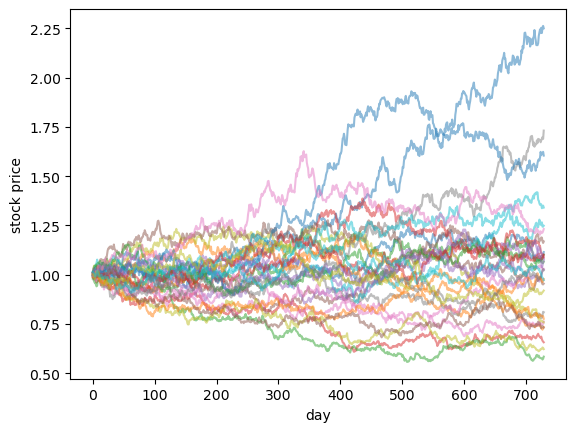

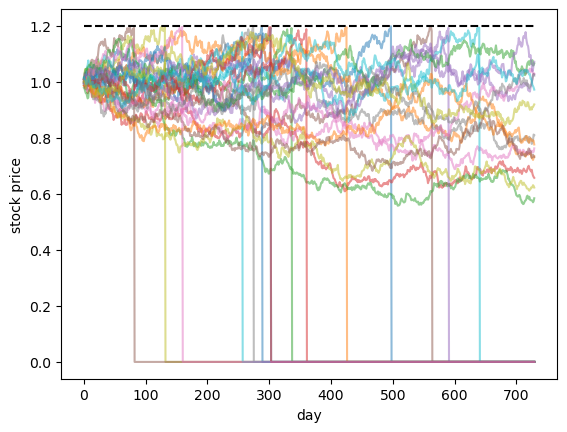

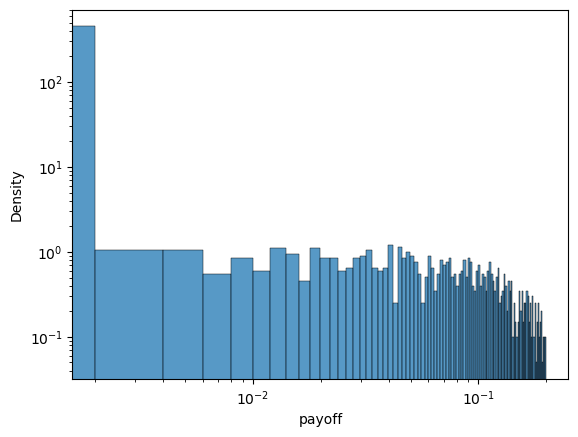

In [90]:
values = []
B = 1000

for i in tqdm(range(B)):
    N = 10000
    returns = pd.DataFrame(norm.rvs(loc = r, scale = vol, size=(T, N)))
    stocks = returns.add(1).cumprod()


    payoffs = UaO_payoff(stocks, K, barrier)
    value = np.mean(payoffs)
    values.append(value)



price = np.mean(values)
se = np.std(values, ddof=1)/np.sqrt(B)

print("price estimate: {}".format(np.mean(values)))
print("error: {}\n".format(np.std(values, ddof=1)/np.sqrt(B)))
alpha = 0.05
print("95% confidence interval({}, {})".format(price - se * norm.cdf(alpha / 2), price + se * norm.cdf(1 - alpha / 2)))

plt.plot(returns.iloc[:,:30].cumsum(), alpha=0.5)
plt.xlabel('day')
plt.ylabel('total returns')
plt.show()

plt.plot(stocks.iloc[:,:30], alpha=0.5)
plt.xlabel('day')
plt.ylabel('stock price')
plt.show()

plt.plot(stocks.iloc[:,:30] * (stocks.iloc[:,:30] < 1.2).cumprod(), alpha=0.5)
plt.plot([0, T], [barrier, barrier], '--', color = 'k')
plt.xlabel('day')
plt.ylabel('stock price')
plt.show()

sns.histplot(payoffs, bins=100, stat='density')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('payoff')
plt.show()